In [ ]:
!pip install ortools

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

# OR TOOLS

In [ ]:
n=50 #num of clients
m=7 #maximum size of order
Q_max=10 #vehicle capacity
v_num=10 #num of vehicles

In [ ]:
np.random.seed(0)

V=[i for i in range(n+1)] #clients with central point

x=np.random.rand(len(V))*100
y=np.random.rand(len(V))*100

Nc=V.copy()
Nc.remove(0)
deliv=[]
demands=[0 for _ in range(len(V))]
while len(Nc):
    mm=np.random.randint(1,m+1)
    a=Nc.pop(np.random.randint(0,len(Nc)))
    demands[V.index(a)]=mm
    b=Nc.pop(np.random.randint(0,len(Nc)))
    demands[V.index(b)]=mm*(-1)
    deliv.append([a,b])

d=[[np.hypot([x[i]-x[j]],[y[i]-y[j]])[0] for j in V] for i in V]

In [ ]:
print(demands)
print(deliv)

[0, 1, -6, 3, -1, -3, 5, 2, 5, -1, -4, 4, -1, -5, -3, -4, 4, -4, -5, 2, 5, 6, -5, -2, -2, 3, 1, -2, -7, 5, -7, 5, -5, 6, 4, -1, 4, -6, -5, -7, -5, 7, 1, 7, 3, 5, 1, -3, 2, -4, 7]
[[44, 14], [42, 9], [34, 10], [3, 5], [20, 40], [6, 18], [31, 22], [19, 27], [46, 35], [41, 28], [45, 38], [33, 2], [1, 12], [16, 49], [21, 37], [48, 24], [43, 30], [50, 39], [7, 23], [29, 32], [11, 15], [25, 47], [36, 17], [26, 4], [8, 13]]


In [ ]:
def create_data_model():
    data = {}
    data['distance_matrix'] = d
    data['pickups_deliveries'] = deliv
    data['demands'] = demands
    data['vehicle_capacities'] = [Q_max for _ in range(v_num)]
    data['num_vehicles'] = v_num
    data['depot'] = 0
    return data


In [ ]:
def get_routes(solution, routing, manager):
  """Get vehicle routes from a solution and store them in an array."""
  # Get vehicle routes and store them in a two dimensional array whose
  # i,j entry is the jth location visited by vehicle i along its route.
  routes = []
  for route_nbr in range(routing.vehicles()):
    index = routing.Start(route_nbr)
    route = [manager.IndexToNode(index)]
    while not routing.IsEnd(index):
      index = solution.Value(routing.NextVar(index))
      route.append(manager.IndexToNode(index))
    routes.append(route)
  return routes

In [ ]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))

In [ ]:
def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Define cost of each arc.
    def distance_callback(from_index, to_index):
        """Returns the manhattan distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Define Transportation Requests.
    for request in data['pickups_deliveries']:
        pickup_index = manager.NodeToIndex(request[0])
        delivery_index = manager.NodeToIndex(request[1])
        routing.AddPickupAndDelivery(pickup_index, delivery_index)
        routing.solver().Add(
            routing.VehicleVar(pickup_index) == routing.VehicleVar(
                delivery_index))
        routing.solver().Add(
            distance_dimension.CumulVar(pickup_index) <=
            distance_dimension.CumulVar(delivery_index))

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION)

    #search_parameters.local_search_metaheuristic = (
     #   routing_enums_pb2.LocalSearchMetaheuristic.SIMULATED_ANNEALING)
    #search_parameters.time_limit.FromSeconds(300)
    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)

    routes = get_routes(solution, routing, manager)

    return routes

In [ ]:
routes=main()

Objective: 33158
Route for vehicle 0:
 0 Load(0) ->  33 Load(6) ->  11 Load(10) ->  15 Load(6) ->  42 Load(7) ->  2 Load(1) ->  48 Load(3) ->  24 Load(1) ->  9 Load(0) ->  41 Load(7) ->  28 Load(0) ->  0 Load(0)
Distance of the route: 316m
Load of the route: 0

Route for vehicle 1:
 0 Load(0) ->  16 Load(4) ->  34 Load(8) ->  49 Load(4) ->  29 Load(9) ->  10 Load(5) ->  31 Load(10) ->  32 Load(5) ->  22 Load(0) ->  0 Load(0)
Distance of the route: 310m
Load of the route: 0

Route for vehicle 2:
 0 Load(0) ->  50 Load(7) ->  3 Load(10) ->  39 Load(3) ->  45 Load(8) ->  19 Load(10) ->  38 Load(5) ->  27 Load(3) ->  7 Load(5) ->  23 Load(3) ->  21 Load(9) ->  5 Load(6) ->  37 Load(0) ->  0 Load(0)
Distance of the route: 306m
Load of the route: 0

Route for vehicle 3:
 0 Load(0) ->  44 Load(3) ->  25 Load(6) ->  1 Load(7) ->  47 Load(4) ->  14 Load(1) ->  43 Load(8) ->  30 Load(1) ->  12 Load(0) ->  0 Load(0)
Distance of the route: 316m
Load of the route: 0

Route for vehicle 4:
 0 Load(0)

In [ ]:
def random_color():
    return tuple(np.random.random() for _ in range(3))

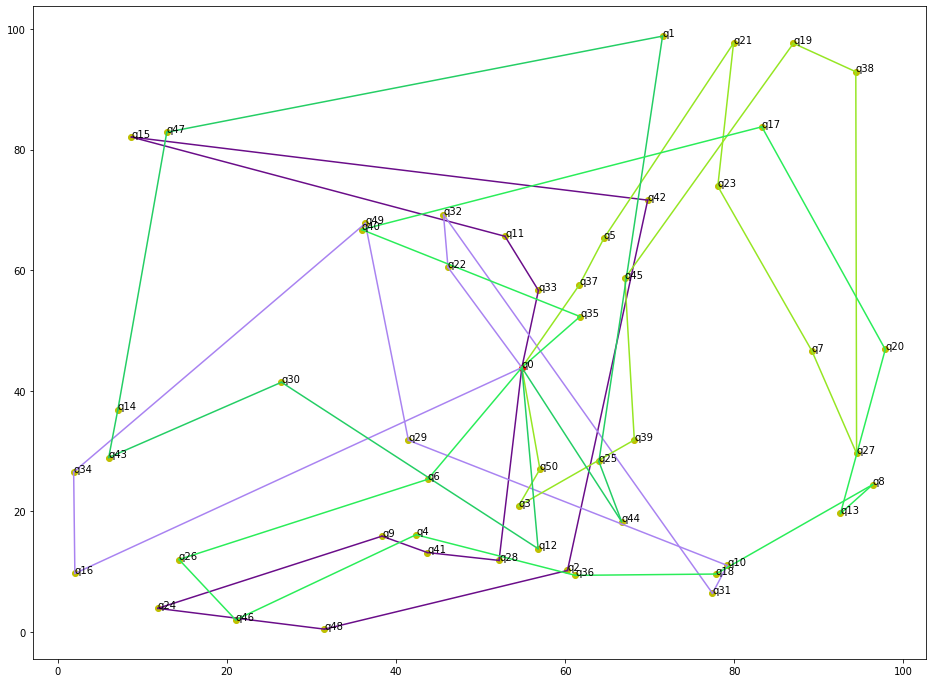

In [ ]:
plt.figure(figsize=(16, 12))
plt.scatter(x[1:],y[1:],c='y')
for i in V:
    #plt.annotate('q{}({})'.format(i, q[i]), (x[i],y[i]))
    plt.annotate('q{}'.format(i), (x[i],y[i]))
plt.scatter(x[0],y[0],c='r')

for route in routes:
    c = random_color()
    for ride in range(len(route)-1):
        i=route[ride]
        j=route[ride+1]
        plt.plot([x[i],x[j]],[y[i],y[j]], c=c)

plt.show()